# Berechung eines Diffusionskoeffozienten aus einer GITT-Messung #

In [27]:
#import der benötigten Bibliotheken

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import splrep, splev
from math import floor, sqrt

Laden der Dateien von lokalem Speicher (Speicherort der Funktion open() muss je nach Nutzer angepasst werden)

In [28]:
infile1 = open(r'C:\Users\Rasmus Bewer\PycharmProjects\pybammproject\Data\GITT\GITT_Curve.txt', 'r')
lines1 = infile1.readlines()
infile2 = open(r'C:\Users\Rasmus Bewer\PycharmProjects\pybammproject\Data\GITT\GITT-OCV-SOC.txt')
lines2 = infile2.readlines()
time = []
E_WE = []
E_CE =[]
SOC = []
step = []

# Hier habe ich die nötigen Python lists initialisiert um dort später Werte-arrays aus den geladenen Dateien einzuspeichern

In [29]:
#Die Spalten aus den geladenen Dateien richtig zuordnen und kommas durch Punkte ersetzen
for line in lines2:
    r = line.split('\t')
    step.append(float(r[0].replace(',','.')))
    SOC.append(float(r[1].replace(',','.')))


for line in lines1:
    r = line.split('\t')
    time.append(float(r[0].replace(',','.')))
    E_WE.append(float(r[1].replace(',', '.')))
    E_CE.append(float(r[2].replace(',', '.'))) 

# Zeile ab jedem tab ('\t') trennen, es entstehen 3 Werte r[0],r[1],r[2]. Die werden den oben initialisierten arrays übergeben
# variablen definition

t_complete = np.asarray(time) # time vector containing the complete data
E_CE = np.asarray(E_CE) # potential vector, contain the complete data
E_WE = np.asarray(E_WE)
F = 96485 # [C/mol] Faraday constant
V_m = 0.01247 # [cm^3/mol] molar Volume of the electrode (cm^3/mol)
S = 2.54*1.5 # [cm^2] electrode contact area, estimation of area*1.5
n_m = 3.597*10**(-4) # number of moles
t_intervall = 8100
D=[]

Definition der Funktionen, welche es erlauben, die gesamte GITT Messung in die einzelnen berechnungsrelevanten Intervalle zu unterteilen. 

In [30]:
def e_we(i):
    if i == 1:
        return E_WE[(t_complete > 300 + (t_intervall * (i - 1))) & (t_complete < 8100 + (t_intervall * (i - 1)))]
    else:
        return E_WE[(t_complete > 0 + (t_intervall * (i - 1))) & (t_complete < 8100 + (t_intervall * (i - 1)))]

def e_ce(l):
    if l == 1:
        return E_CE[(t_complete > 300 + (t_intervall * (l - 1))) & (t_complete < 8100 + (t_intervall * (l - 1)))]
    else:
        return E_CE[(t_complete > 0 + (t_intervall * (l - 1))) & (t_complete < 8100 + (t_intervall * (l - 1)))]

def t(j):
    if j == 1:
        return t_complete[(t_complete > 300+(t_intervall*(j-1))) & (t_complete < 8100+(t_intervall*(j-1)))]
    else:
        return t_complete[(t_complete > 0+(t_intervall*(j-1))) & (t_complete < 8100+(t_intervall*(j-1)))]

# Wenn j ==1 ist nehme ich erst Daten ab der 300. Sekunde der GITT Messung, da die Daten davor die Berechnung des 
# Koeffizienten verfälschen. ab dem zweiten Lade bzw. entlade und relaxation schritt Ist das Intervall 8100 Sekunden
# breit. Das entspricht 2h 15min. Der Wert ist üer die Variable t_intervall anpassbar

Hier beginnt die For-Schleife in der ich Die zuvor definierten Funktionen nutze um für jeden GITT Schritt, bestehend aus Laden/Entladen und relaxation, den Diffusionskoeffizient zu berechnen. 
D = $\dfrac{4}{\pi \times \tau}\times\left(\dfrac{n_m \times V_m}{S}\right)^2\times\left(\dfrac{\Delta E_s}{\Delta E_t}\right)^2$

In [31]:
for x in range(1, int((t_complete[-1]-300)/t_intervall)):

    # Hier nehme ich die Daten aus dem jeweiligen GITT schritt, um durch diese Punkte eine Gerade zu legen und so fest zu stellen
    # ob es sich um einen Lade(pos. steigung) oder Entlade(neg. steigung) schritt handelt. Dazu nutze ich den relaxation Teil der Daten
    
    e_i = e_we(i=x)[t(j=x) > 1200 + (t_intervall * (x - 1))]

    # der Parameter m bezeichnet die Anzahl an Datenpunkten des Intervalls
    # s ist ein parameter von splrep und hat Einfluss auf die Interpolation 

    m = floor((len(e_i)+len(t(j=x)))/2)
    s = np.max([m-sqrt(2*m),m+sqrt(2*m)])
    spline = splrep(t(j=x)[t(j=x) > 1200 + t_intervall * (x - 1)], e_i, k=1, s=s)
    interp = splev(t(j=x)[t(j=x) > 1200 + t_intervall * (x - 1)], spline)


    # Hier wird der Diffusionskoeffizient berechnet. Das Delta Es und Et wird aus den Datenpunkten errechnet und dann in die Gleichung
    # eingesetzt. Die erste If bedingung prüft jeweils, ob die Steigung der interpolierenden geraden pos. oder neg. ist.
    # Die exception, dass ein Nullteiler fehler ignoriert werden soll ist evtl. überflüssig

    if (interp[-1]-interp[0]) > 0:
        delta_Es = np.abs(e_we(i=x)[-1] - e_we(i=x)[0])
        delta_Et = np.abs(np.min(e_we(i=x)) - e_we(i=x)[t(j=x) >= 300 + (t_intervall * (x - 1))][0])
        # print(e(i=x)[t(j=x)>=300*x][0])
        try:
            diff_coeff = ((4 / (np.pi * 900)) * ((n_m * V_m / S) ** 2) * (delta_Es/delta_Et))
        except ZeroDivisionError:
            continue
        D.append(diff_coeff)
    else:
        delta_Et = np.abs(np.max(e_we(i=x)) - e_we(i=x)[t(j=x) >= 300 + (t_intervall * (x - 1))][0]) # +(t_intervall*(x-1)) anstatt *x
        delta_Es = np.abs(np.min(e_we(i=x)) - e_we(i=x)[-1])
        # print(e(i=x)[t(j=x)>=300*x][0])
        try:
            diff_coeff = ((4 / (np.pi * 900)) * ((n_m * V_m / S) ** 2) * (delta_Es / delta_Et))
        except ZeroDivisionError:
            continue
        D.append(diff_coeff)

Zuletzt wird Der Diffusionskoeffizient über dem SOC geplottet. Zusätzlich wird einmal die gesamte GITT Messung über der Zeit geplottet

97.33372 39


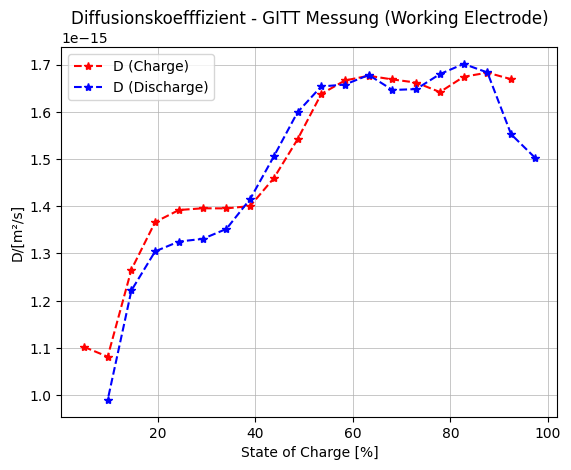

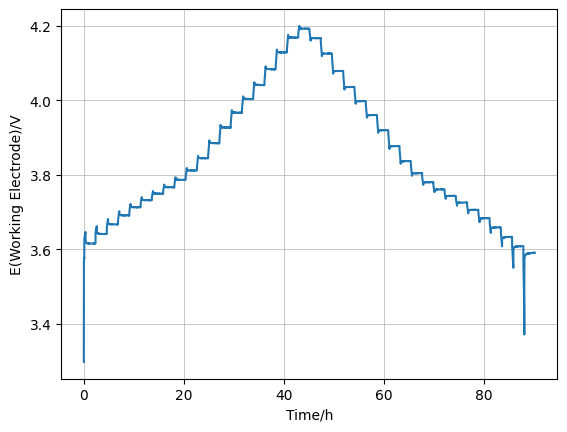

In [32]:
SOC = SOC[1:-1]
print(SOC[19],len(D))

plt.figure()
plt.xlabel('State of Charge [%]')
plt.ylabel('D/[m²/s]')
plt.grid(True, linewidth = 0.5)
plt.title('Diffusionskoefffizient - GITT Messung (Working Electrode)')
plt.plot(SOC[0:19], D[0:19],'r--*',SOC[19:-1],D[19:-1],'b--*')
plt.legend(['D (Charge)', 'D (Discharge)'])

plt.figure()
plt.xlabel('Time/h')
plt.ylabel('E(Working Electrode)/V')
plt.grid(True, linewidth = 0.5)
plt.plot(t_complete / 3600, E_WE)
plt.show()
print()